In [107]:
import re
import numpy as np
import time
from pathlib import Path
from typing import Optional, Union
from geecs_python_api.controls.interface import GeecsDatabase
from geecs_python_api.controls.devices.geecs_device import GeecsDevice
from datetime import datetime

import png
import os
import yaml
import imageio

import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter

import subprocess
import platform
from matplotlib.colors import LinearSegmentedColormap

GeecsDevice.exp_info = GeecsDatabase.collect_exp_info('Undulator')

In [415]:
#Some functions below to establish paths to data, analysis directory. Automatically detects if the computre is on the domain, if it is
#use the given path. Other wise, check hostname and decide path based off of that

def get_domain_windows():
    try:
        # Simplifying command execution, focusing on parsing the domain directly
        result = subprocess.check_output(['systeminfo'], stderr=subprocess.STDOUT, text=True)
        domain_line = next((line for line in result.splitlines() if "Domain" in line), None)
        if domain_line:
            return domain_line.split(':')[1].strip()
    except Exception as e:
        # Logging or handling the exception can be done here if necessary
        return None

def get_base_path():
    # Attempt to retrieve the domain, falling back to hostname if needed
    domain = get_domain_windows()
    hostname = platform.node()

    # Directly mapping conditions to base paths, raising an error if none match
    if domain == 'loasis.gov':
        return 'Z:\\data\\Undulator'
    elif hostname == 'Samuels-MacBook-Pro.local':
        return '/Volumes/vol1/data/Undulator'
    else:
        raise ValueError('Attempting to use an unknown computer. Path to data is unknown.')


def get_current_date():
    month_dict2= {
        "01": "Jan", "02": "Feb", "03": "Mar", "04": "04-Apr",
        "05": "May", "06": "Jun", "07": "07-Jul", "08": "08-Aug",
        "09": "Sep", "10": "Oct", "11": "11-Nov", "12": "12-Dec"
    }

    # Get the current date and time
    current_date_time = datetime.now()

    month = month_dict2[current_date_time.strftime("%m")]
    year = current_date_time.strftime("%Y")
    day = current_date_time.strftime("%d")

    return year, month, day

def create_data_path(year, month, day, scan_number):
    # Mapping of month names to their abbreviated forms with month numbers
    month_dict = {
        "Jan": "01-Jan", "Feb": "02-Feb", "Mar": "03-Mar", "Apr": "04-Apr",
        "May": "05-May", "Jun": "06-Jun", "Jul": "07-Jul", "Aug": "08-Aug",
        "Sep": "09-Sep", "Oct": "10-Oct", "Nov": "11-Nov", "Dec": "12-Dec"
    }

    # Extracting year's last two digits and month number from month_dict
    year_short = str(year)[-2:]
    month_num = month_dict[month][:2]

    # Constructing paths for raw and analysis data
    date_folder = f"{year_short}_{month_num}{str(day).zfill(2)}"  # Ensures day is zero-padded
    base_folder = Path(base_path) / f"Y{year}" / month_dict[month] / date_folder
    raw_data_path = base_folder / "scans" / f"Scan{scan_number:03d}"
    analysis_data_path = base_folder / "analysis" / f"Scan{scan_number:03d}"

    return str(raw_data_path), str(analysis_data_path)

def read_imaq_png_image(file_path: Union[Path, str]) -> np.ndarray:
    """ Read PNG file as output by NI IMAQ, which uses an uncommon format.
    """
    png_reader = png.Reader(file_path.open('rb'))

    # read operations returns rows as a generator. it also adds png headers
    # as attributes to png_reader, including sbit
    width, height, rows, info = png_reader.read()

    # NI IMAQ images use 16 bits per pixel (uncompressed) but often only 
    # the left 12 bits for the data, which is given in the sbit header. 
    # PNG readers don't account for this, so we right shift manually.
    bitdepth = info['bitdepth']
    image = np.array(list(rows), f'uint{bitdepth:d}')

    if png_reader.sbit is None:
        return image
    else:
        significant_bits = ord(png_reader.sbit)
        return np.right_shift(image, bitdepth - significant_bits)

def create_average_image_file_name(device, station = None):
    filename = f'{device}{"" if station is None else "_"+station}{"_average"}_16bit.png'
    return filename

def create_avg_image(scan_dir_base, analysis_dir_base, device, station=None, show_image=False):
    image_dir = Path(scan_dir_base) / device
    all_imgs = []
    
    for path in image_dir.glob('*.png'):  # Assuming images are in PNG format
        img = read_imaq_png_image(path)
        all_imgs.append(img)

    if not all_imgs:  # Early return if no images found
        print("No images found in directory:", image_dir)
        return

    avg_img = np.mean(all_imgs, axis=0)
    avg_img_uint16 = avg_img.astype(np.uint16)
    
    if show_image:
        plt.imshow(avg_img_uint16, cmap=custom_cmap, vmin=0, vmax=np.max(avg_img_uint16))
        plt.colorbar(label="Scale")
        plt.title("2D Array Visualization")
        plt.show()
    
    analysis_dir = Path(analysis_dir_base)
    analysis_dir.mkdir(parents=True, exist_ok=True)  # Simplified directory check and creation
    
    # filename = f'{device}{"" if station is None else "_"+station}{"_average"}_16bit.png'
    filename = create_average_image_file_name(device,station)
    imageio.imwrite(analysis_dir / filename, avg_img_uint16)
    print(f"Saved image to: {analysis_dir / filename}")

# Helper function for CMYK to RGB conversion
def cmyk_to_rgb(c, m, y, k):
    """Convert CMYK values to RGB."""
    r = 255 * (1.0 - c) * (1.0 - k)
    g = 255 * (1.0 - m) * (1.0 - k)
    b = 255 * (1.0 - y) * (1.0 - k)
    return r / 255.0, g / 255.0, b / 255.0


def get_analysis_settings(device, station=None):
    """
    Determine and load the analysis settings based on the device and optional station.

    Args:
        device (str): The name of the device, which may include a numerical suffix.
        station (str, optional): The name of the station, relevant for some devices.

    Returns:
        dict: The loaded analysis settings from the YAML configuration.
    """
    # Define a strategy to select the configuration file based on device name patterns
    if "UC_UndulatorRad2" in device:
        config_path = "Rad2_analysis_settings.yml"
    elif "UC_VisaEBeam" in device:
        # Assuming all UC_VisaEBeamX devices share the same config structure
        config_path = "visa_analysis_settings.yml"
    else:
        # Fallback to a default config if the device pattern is not recognized
        config_path = "default_config.yml"
    
    # Attempt to load the configuration file
    try:
        with open(config_path, 'r') as file:
            cam_settings = yaml.safe_load(file)
    except FileNotFoundError:
        print(f"Error: The configuration file '{config_path}' was not found.")
        return {}
    
    # Extract the analysis settings for the specific device or station
    if "UC_UndulatorRad2" in device and station:
        # For UC_UndulatorRad2, settings may be under the station name
        analysis_settings = cam_settings.get(station, {})
    else:
        # For other devices, settings are expected under the device name
        analysis_settings = cam_settings.get(device, {})

    return analysis_settings

def load_and_preprocess_image(image_path, analysis_settings):
    """
    Load an image and apply initial preprocessing steps.

    Args:
        image_path (str): Path to the image file.

    Returns:
        numpy.ndarray: Preprocessed image.
    """
    image = cv2.imread(str(image_path), cv2.IMREAD_UNCHANGED)

    cropped_image = image[analysis_settings['Top ROI']:analysis_settings['Top ROI'] + analysis_settings['Size_Y'],
                          analysis_settings['Left ROI']:analysis_settings['Left ROI'] + analysis_settings['Size_X']]

    return cropped_image


def apply_masks_and_filters(image, analysis_settings):
    """
    Apply cropping, masks, background subtraction, and filters to the image.

    Args:
        image (numpy.ndarray): The image to process.
        analysis_settings (dict): Settings for processing, including cropping coordinates, mask settings, and filter settings.

    Returns:
        numpy.ndarray: The processed image.
    """
    processed_image = image

    # Apply masks (assuming `create_cross_mask` is a function you have defined)
    if 'Cross1' in analysis_settings:
        mask1 = create_cross_mask(processed_image, analysis_settings['Cross1'], analysis_settings['Rotate'])
        processed_image *= mask1

    if 'Cross2' in analysis_settings:
        mask2 = create_cross_mask(processed_image, analysis_settings['Cross2'], analysis_settings['Rotate'])
        processed_image *= mask2

    # # Subtract background level and apply filters
    # cropped_image = np.maximum(cropped_image - analysis_settings['Background Level'], 0)

    processed_image = processed_image.astype('float32')
    processed_image = processed_image - analysis_settings['Background Level']
    processed_image[processed_image < 0] = 0
    
    for _ in range(analysis_settings.get('Median Filter Cycles', 0)):
        processed_image = median_filter(processed_image, size=analysis_settings['Median Filter Size'])

    for _ in range(analysis_settings.get('Gaussian Filter Cycles', 0)):
        processed_image = gaussian_filter(processed_image, sigma=analysis_settings['Gaussian Filter Size'])

    return processed_image


def save_processed_image(image, image_path):
    """
    Save the processed image to disk.

    Args:
        image (numpy.ndarray): The image to save.
        image_path (str): Original image path to derive the save location and filename.
    """
    raw_image_filename = os.path.splitext(os.path.basename(image_path))[0] + "_raw_processed.png"
    raw_image_save_path = os.path.join(os.path.dirname(image_path), raw_image_filename)
    cv2.imwrite(raw_image_save_path, image.astype('uint16'))
    # print(f"Processed image saved to {raw_image_save_path}")

def display_and_save_customized_image(image, image_path, show_image=True):
    """
    Display the image using matplotlib and save the displayed image to disk.

    Args:
        image (numpy.ndarray): The image to display and save.
        image_path (str): Original image path to derive the save location and filename.
        show_image (bool): Whether to show the image in a matplotlib window.
    """

    # Check if the maximum value in the image is greater than 0
    if np.max(image) > 0:
        display_image = image / np.max(image) * (2**8 - 1)
    else:
        # This creates a uniformly black image in the context of grayscale uint8 images
        display_image = np.zeros_like(image)

    display_image = display_image.astype('uint8')


    fig, ax = plt.subplots(figsize=(4 , 4 ))

    # Plot the image data on the respective subplot
    ax.imshow(display_image, cmap=custom_cmap)
            
    # Restore the axis grid and ticks
    ax.grid(True)  # Turn on the grid
    ax.set_xticks([])  # Set the x-ticks to an empty list if you don't want any ticks
    ax.set_yticks([])  # Set the y-ticks to an empty list if you don't want any ticks
    if "UC_Visa" in str(image_path):
        # If you want to show the grid ticks, you can specify them explicitly, e.g.:
        ax.set_xticks([0, 50, 100, 150,200,250,300])
        ax.set_yticks([0, 50, 100, 150,200,250,300])

    if "UC_UndulatorRad2" in str(image_path):
        # If you want to show the grid ticks, you can specify them explicitly, e.g.:
        ax.set_xticks([0,100,200,300,400,500])
        ax.set_yticks([0,100,200,300,400])

    # Save the customized image
    fig.tight_layout()
    save_path = os.path.splitext(image_path)[0] + "_customized.png"
    fig.savefig(save_path, bbox_inches='tight', pad_inches=0.01)
    if show_image:
        None
    else:
        plt.close(fig)  # Close the figure to free memory

    return save_path

def plot_image_with_customizations(image_path, analysis_settings, show_image=True):
    """
    Main function to load, process, display, and save an image with customizations.

    Args:
        image_path (str): Path to the image file.
        analysis_settings (dict): Settings for image processing and customization.
        show_image (bool): Whether to display the processed image.
    """
    image = load_and_preprocess_image(image_path, analysis_settings)
    processed_image = apply_masks_and_filters(image, analysis_settings)
    save_processed_image(processed_image, image_path)
    
    # if show_image:
    save_path = display_and_save_customized_image(processed_image, image_path, show_image=show_image)

    return processed_image, save_path

def image_analysis(image):
    """
    Analyze the image to calculate the center of mass, second moment, FWHM, 
    and position of max value of both horizontal and vertical projections.

    Args:
    - image (np.array): A grayscale image array.

    Returns:
    - dict: Analysis results containing centers of mass, second moments,
            FWHMs, and positions of max values for both directions.
    """

    # Check if the image is all zeros or the sum of the projections are zero
    if np.all(image == 0) or np.sum(image) == 0:
        # Return a dictionary with all values set to 0 if image is all zeros or sum of projections is zero
        return {
            'Center of Mass': [0, 0],
            'Second Moment': [0, 0],
            'FWHM': [0, 0],
            'Max Value Position': [0, 0],
            'Sum Counts': 0,
            'Max Count': 0
        }
    
    # Calculate the projections by summing the image array along the axes
    horizontal_projection = np.sum(image, axis=0)  # Sum over rows for each column
    vertical_projection = np.sum(image, axis=1)  # Sum over columns for each row
    
    # Calculate the center of mass (first moment) for the projections
    def center_of_mass(projection):
        positions = np.arange(len(projection))
        return np.sum(positions * projection) / np.sum(projection)
    
    # Calculate the second moment (variance) for the projections
    def second_moment(projection, com):
        positions = np.arange(len(projection))
        return np.sqrt(np.sum((positions - com)**2 * projection) / np.sum(projection))
    
    # Calculate the Full Width at Half Maximum (FWHM) for the projections
    def fwhm(projection):
        half_max = np.max(projection) / 2
        indices_above_half_max = np.where(projection >= half_max)[0]
        return np.abs(indices_above_half_max[-1] - indices_above_half_max[0])

    # Calculate the position of the max value for the projections
    def max_value_position(projection):
        return np.argmax(projection)

    # Perform calculations
    com_horizontal = center_of_mass(horizontal_projection)
    com_vertical = center_of_mass(vertical_projection)
    moment2_horizontal = second_moment(horizontal_projection, com_horizontal)
    moment2_vertical = second_moment(vertical_projection, com_vertical)
    fwhm_horizontal = fwhm(horizontal_projection)
    fwhm_vertical = fwhm(vertical_projection)
    max_pos_horizontal = max_value_position(horizontal_projection)
    max_pos_vertical = max_value_position(vertical_projection)
    sum_counts = np.sum(horizontal_projection)
    
    # Compile results
    results = {
        'Center of Mass': [com_horizontal, com_vertical],
        'Second Moment': [moment2_horizontal, moment2_vertical],
        'FWHM': [fwhm_horizontal, fwhm_vertical],
        'Max Value Position': [max_pos_horizontal, max_pos_vertical],
        # 'Projections': [horizontal_projection, vertical_projection],
        'Sum Counts': sum_counts,
        'Max Count': np.max(iamge)
        
    }

    return results

def full_process(year, month, day, scan_number, device, station):
    
    scan_dir_base, analysis_dir_base = create_data_path(year, month, day, scan_number)
    
    analysis_settings = get_analysis_settings(device, station)
    filename = create_average_image_file_name(device,station)
    image_path = Path(analysis_dir_base) / filename
    
    test, save_path = plot_image_with_customizations(image_path , analysis_settings, show_image=False)

    res = image_analysis(test)
    # sum_counts = res['Sum Counts']

    return save_path, res

def create_next_special_scan_directory(working_dir, special_scan_base_name):
    # Find existing directories with the base name
    existing_dirs = [dir for dir in working_dir.iterdir() if dir.is_dir() and special_scan_base_name in dir.name]
    
    # Extract suffix numbers and find the next available number
    suffixes = [int(dir.name.replace(special_scan_base_name, '')) for dir in existing_dirs if dir.name.replace(special_scan_base_name, '').isdigit()]
    next_number = max(suffixes) + 1 if suffixes else 1
    
    # Create new directory with the next number
    new_dir_name = f"{special_scan_base_name}{next_number}"
    new_dir_path = working_dir / new_dir_name
    new_dir_path.mkdir(exist_ok=True)  # Create the directory, ignore if it already exists
    
    return new_dir_path

def undulator_screen_scan():
    #undulator position scan with post analysis
    import threading


    use_threading = False
    threads=[]
    year, month, day = get_current_date()
    scan_dir_base, analysis_dir_base = create_data_path(year, month, day, scan_number)
    special_scan_base_name = 'undulator_screen_scan'
    working_dir = Path(analysis_dir_base).parent 
    undulator_scan_dir = create_next_special_scan_directory(working_dir,special_scan_base_name)

    scan_numbers = []
    for i in range(len(plunger_var_names)):
        retract_all_plungers()
        time.sleep(1)
        visa_plungers.set(plunger_var_names[i],'on')  
        time.sleep(1)
        print('set plunger: ',i)
        velmex.set("Position",rad2_positions[i])
        print('moved velmex to : ',rad2_positions[i])
        time.sleep(2)
        velmex.no_scan(comment="no scan on visa plunger: "+plunger_var_alias[i],shots = 5)
        scan_number = velmex.last_scan_number()
        scan_dir_base, analysis_dir_base = create_data_path(year, month, day, scan_number)
    
        if use_threading:
            ### code for threading the average image generation
            t1 = threading.Thread(target=create_avg_image, args=(scan_dir_base, analysis_dir_base, f'UC_VisaEBeam{i+1}', None),kwargs={'show_image': True})
            t2 = threading.Thread(target=create_avg_image, args=(scan_dir_base, analysis_dir_base, 'UC_UndulatorRad2', f'Station{i+1}'),kwargs={'show_image': True})
            t1.start()
            t2.start()
        
            # Add the threads to the list
            threads.append(t1)
            threads.append(t2)
    
        else:
            create_avg_image(scan_dir_base, analysis_dir_base, f'UC_VisaEBeam{i+1}', show_image = True)
            create_avg_image(scan_dir_base, analysis_dir_base, f'UC_UndulatorRad2',station = f'Station{i+1}', show_image = True)
    
        scan_numbers.append(scan_number)
    
    if use_threading:
        # Wait for all threads to finish
        for thread in threads:
            thread.join()

    return scan_numbers, undulator_scan_dir

def convert_types(obj):
    if isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {key: convert_types(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [convert_types(value) for value in obj]
    else:
        return obj


def create_image_grids(device,scan_numbers,undulator_scan_dir):

    fig_paths = []
    all_stats = {}
    
    # Determine the base file name based on the device type
    if device == "UC_UndulatorRad2":
        file_save_name = 'urad2_image_grid.png'
        stats_save_name = 'urad2_stats.yml'
    elif "UC_VisaEBeam" in device:
        file_save_name = 'visa_image_grid.png'
        stats_save_name = 'visa_stats.yml'
    else:
        print(f"Warning: Unrecognized device '{device}'.")
        return None  # or handle this case as appropriate

    for i, scan_number in enumerate(scan_numbers):
        # Adjust parameters based on device type
        station_suffix = i + 1  # Assumes scan_numbers are sequentially increasing
        if device == "UC_UndulatorRad2":
            device_name = device
            station_name = f"Station{station_suffix}"
        else:  # UC_VisaEBeamX
            device_name = f"{device}{station_suffix}"
            station_name = None  # Assuming this is how it's meant to be used for UC_Visa devices
        print(device_name)
        stats_key = f'{device_name}_{station_name}' if station_name else device_name
        # Perform the full process with adjusted parameters
        fig_path, stats = full_process(year, month, day, scan_number, device_name, station_name)
        fig_paths.append(fig_path)
        all_stats[stats_key] = stats
    
    grid_rows = 2
    grid_cols = 4
    fig, axs = plt.subplots(grid_rows, grid_cols, figsize=(15, 7))
    
    for ax, plot_path in zip(axs.flat, fig_paths):
        img = plt.imread(plot_path)
        ax.imshow(img)
        ax.axis('off')  # Optionally hide the axis
    
    # Adjust layout
    plt.tight_layout()
    # Save the figure
    save_path = Path(undulator_scan_dir)/file_save_name  # Specify your save path here
    fig.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()

    all_stats_converted = convert_types(all_stats)

    # # Save the stats dictionary to a file
    with open(Path(undulator_scan_dir) / stats_save_name, 'w') as file:
        yaml.safe_dump(all_stats_converted, file, default_flow_style=False)

    return all_stats,all_stats_converted


#Define the custom CMYK colors and convert them to RGB
cmyk_colors = [(0, 0, 0, 0), (0.1, 0.1, 0.1, 0.1), (1, 0.84, 0, 0.15), (0, 0.84, 1, 0), (0, 0, 1, 0)]
rgb_colors = [cmyk_to_rgb(*cmyk) for cmyk in cmyk_colors]
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", rgb_colors)


# establish base path to data
try:
    base_path = get_base_path()
except ValueError as e:
    print(f'Error: {e}')

In [7]:
visa_plungers = GeecsDevice('U_VisaPlungers')
velmex = GeecsDevice('U_Velmex')

plunger_var_names = np.flip(["DigitalOutput.Channel 0","DigitalOutput.Channel 1","DigitalOutput.Channel 2","DigitalOutput.Channel 3","DigitalOutput.Channel 4",
"DigitalOutput.Channel 5", "DigitalOutput.Channel 6","DigitalOutput.Channel 7"])

plunger_var_alias = np.flip(["visa8","visa7","visa6","visa5","visa4","visa3","visa2","visa1"])

rad2_positions = [3954,3470,2987,2476.3,1991.2,1498.4,993.3,506.5]



In [8]:
def retract_all_plungers():
    for plunger_name in plunger_var_names:
        visa_plungers.set(plunger_name, 'off')
        time.sleep(0.5)

In [356]:
#execute an undulator screen scan
scan_numbers, undulator_scan_dir = undulator_screen_scan()

#do some post processing
create_image_grids("UC_UndulatorRad2",scan_numbers,undulator_scan_dir)
create_image_grids("UC_VisaEBeam",scan_numbers,undulator_scan_dir)

In [410]:



year = '2024'
month = 'Mar'
day = '21'
scan_numbers = [38,39,40,41,42,43,44,45]

scan_dir_base, analysis_dir_base = create_data_path(year, month, day, scan_numbers[0])
special_scan_base_name = 'undulator_screen_scan'
working_dir = Path(analysis_dir_base).parent 

undulator_scan_dir = create_next_special_scan_directory(working_dir,special_scan_base_name)

create_image_grids("UC_UndulatorRad2",scan_numbers,undulator_scan_dir)
create_image_grids("UC_VisaEBeam",scan_numbers,undulator_scan_dir)

UC_UndulatorRad2
UC_UndulatorRad2
UC_UndulatorRad2
UC_UndulatorRad2
UC_UndulatorRad2
UC_UndulatorRad2
UC_UndulatorRad2
UC_UndulatorRad2
UC_VisaEBeam1
UC_VisaEBeam2
UC_VisaEBeam3
UC_VisaEBeam4
UC_VisaEBeam5
UC_VisaEBeam6
UC_VisaEBeam7
UC_VisaEBeam8


In [389]:
# spot check a single scan, device combo

scan_number = 40
year = '2024'
month = 'Mar'
day = '21'
device = "UC_UndulatorRad2"
station = 'Station3'
# device = "UC_VisaEBeam2"
# station = None
full_process(year, month, day, scan_number, device, station)

('/Volumes/vol1/data/Undulator/Y2024/03-Mar/24_0321/analysis/Scan040/UC_UndulatorRad2_Station3_average_16bit_customized.png',
 {'Center of Mass': [255.6663589800442, 202.8411926559601],
  'Second Moment': [73.10477765930614, 36.40379183922668],
  'FWHM': [172, 82],
  'Max Value Position': [247, 206],
  'Projections': [array([4.41156483e+00, 4.08948708e+00, 3.51114535e+00, 2.78761744e+00,
          2.04208708e+00, 1.37679303e+00, 8.52012336e-01, 4.82660353e-01,
          2.49659777e-01, 1.17615648e-01, 5.03266416e-02, 1.95017494e-02,
          6.79803500e-03, 2.09635682e-03, 5.43246279e-04, 8.92226890e-05,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000

In [352]:
# fig_paths = []
# all_coords=[]
# for i in [1,2,3,4,5,6,7,8]:
#     device = "UC_UndulatorRad2"
#     scan_number = 37+i
#     fig_path, coords = full_process(year, month, day, scan_number, device, f"Station{i}")
#     fig_paths.append(fig_path)
#     all_coords.append(coords)

fig_paths = []
all_coords=[]
for i in [1,2,3,4,5,6,7,8]:
    device = "UC_UndulatorRad2"
    scan_number = 37+i
    fig_path, coords = full_process(year, month, day, scan_number, device, f"Station{i}")
    fig_paths.append(fig_path)
    all_coords.append(coords)


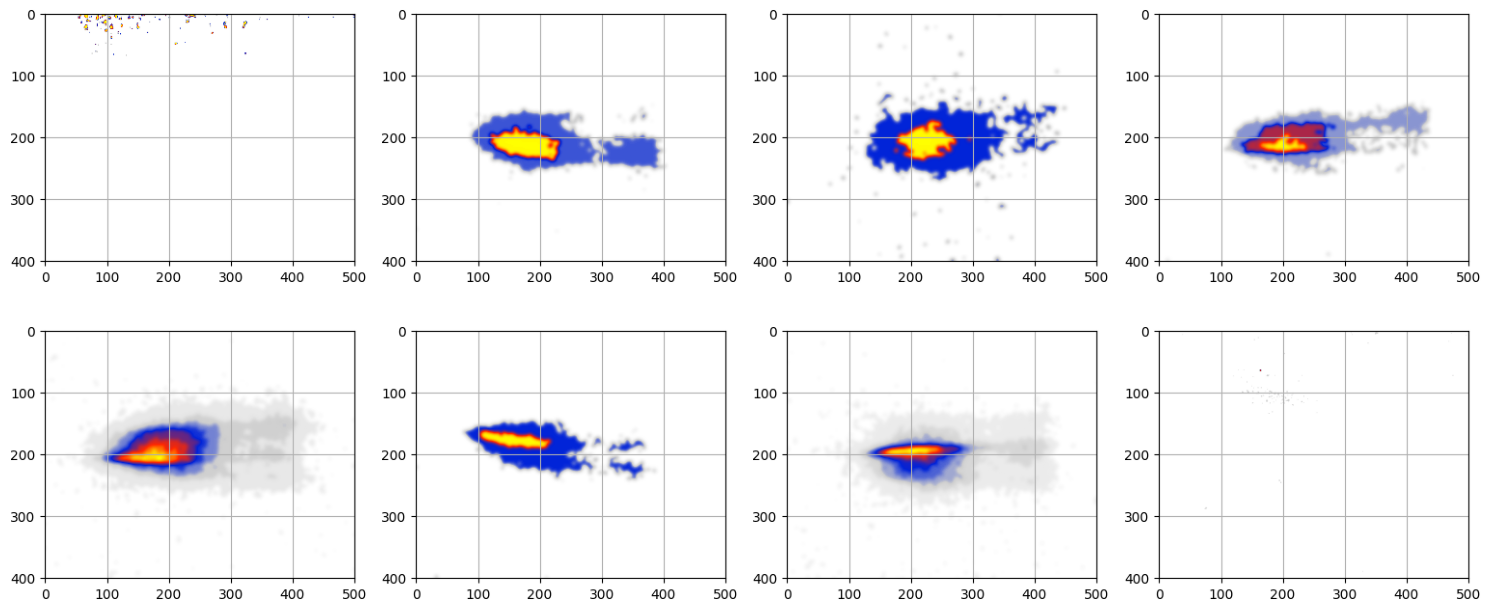

In [354]:
grid_rows = 2
grid_cols = 4
fig, axs = plt.subplots(grid_rows, grid_cols, figsize=(15, 7))

for ax, plot_path in zip(axs.flat, fig_paths):
    img = plt.imread(plot_path)
    ax.imshow(img)
    ax.axis('off')  # Optionally hide the axis

# Adjust layout
plt.tight_layout()
plt.show()

In [369]:
scan_number = 46
year = '2024'
month = 'Mar'
day = '21'
st = 900
scan_dir_base, analysis_dir_base = create_data_path(year, month, day, scan_number)

# create_avg_image(scan_dir_base, analysis_dir_base, f'UC_VisaEBeam{st}', show_image = True)
# create_avg_image(scan_dir_base, analysis_dir_base, f'UC_UndulatorRad2',station = f'Station{st}', show_image = True)


Created or found existing directory: /Volumes/vol1/data/Undulator/Y2024/03-Mar/24_0321/analysis/undulator_screen_scan2


In [203]:
image_path
os.path.splitext(image_path)[0]

'/Volumes/vol1/data/Undulator/Y2024/03-Mar/24_0321/analysis/Scan039/UC_VisaEBeam2_average_16bit'

In [395]:
all_stats[1]

{'Center of Mass': [203.4683572154643, 197.0620827838903],
 'Second Moment': [35.498344104789254, 13.02368639739631],
 'FWHM': [17, 21],
 'Max Value Position': [190, 192],
 'Projections': [array([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+0